In [ ]:
# default_exp experiment

# experiment
> From scratch (& bare bones) Experiment Management.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [ ]:
#export
from lemonade.setup import * #for GVs
from lemonade.preprocessing.vocab import * #for loading vocabs
from lemonade.preprocessing.transform import * #for loading ptlist thru EHRData
from lemonade.data import * #for EHRData
from lemonade.learn import * #for RunHistory
from lemonade.metrics import * #for auroc_score
from lemonade.models import * #for the models
from fastai.imports import *

In [ ]:
#export
from addict import Dict

In [ ]:
#hide
from nbdev.showdoc import *

## YAML & Addict

### YAML
Putting all configuration needed for running an experiment into a YAML file .. 

In [ ]:
with open('./experiments/lstm_base/experiment.yaml', 'rb') as f:
    exp = yaml.full_load(f)

In [ ]:
exp

{'config': {'name': 'lstm_base',
  'path': './experiments',
  'desc': 'Baseline settings for EHR_LSTM experiments',
  'checkpoint_path': './models'},
 'params': {'data_params': {'dataset_path': './datasets/synthea/1K',
   'labels': ['diabetes', 'stroke', 'alzheimers', 'coronaryheart'],
   'age_start': 0,
   'age_stop': 20,
   'age_in_months': False,
   'bs': 128,
   'num_workers': 0,
   'lazy_load_gpu': True},
  'optim_params': {'optim': 'Adagrad',
   'lr': 0.01,
   'lr_decay': 0,
   'weight_decay': 0.0},
  'model_params': {'model': 'LSTM',
   'αd': 0.5736,
   'lstm_layers': 4,
   'linear_layers': 4,
   'initrange': 0.3,
   'bn': False,
   'input_drp': 0.3,
   'lstm_drp': 0.3,
   'linear_drp': 0.3,
   'zero_bn': False}}}

In [ ]:
exp['params']['model_params']

{'model': 'LSTM',
 'αd': 0.5736,
 'lstm_layers': 4,
 'linear_layers': 4,
 'initrange': 0.3,
 'bn': False,
 'input_drp': 0.3,
 'lstm_drp': 0.3,
 'linear_drp': 0.3,
 'zero_bn': False}

In [ ]:
print(exp['params']['model_params']['lstm_layers'])

4


In [ ]:
exp['params']['data_params']['labels']

['diabetes', 'stroke', 'alzheimers', 'coronaryheart']

### Addict

Once we import Addict, like this ..
```python
from addict import Dict
```
It allows us to **access dict keys like an attribute**. 

[A discussion on StackOverflow](https://stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute) details other options like AttrDict and Munch.

In [ ]:
exp_addict = Dict(exp)

In [ ]:
exp_addict

{'config': {'name': 'lstm_base',
  'path': './experiments',
  'desc': 'Baseline settings for EHR_LSTM experiments',
  'checkpoint_path': './models'},
 'params': {'data_params': {'dataset_path': './datasets/synthea/1K',
   'labels': ['diabetes', 'stroke', 'alzheimers', 'coronaryheart'],
   'age_start': 0,
   'age_stop': 20,
   'age_in_months': False,
   'bs': 128,
   'num_workers': 0,
   'lazy_load_gpu': True},
  'optim_params': {'optim': 'Adagrad',
   'lr': 0.01,
   'lr_decay': 0,
   'weight_decay': 0.0},
  'model_params': {'model': 'LSTM',
   'αd': 0.5736,
   'lstm_layers': 4,
   'linear_layers': 4,
   'initrange': 0.3,
   'bn': False,
   'input_drp': 0.3,
   'lstm_drp': 0.3,
   'linear_drp': 0.3,
   'zero_bn': False}}}

In [ ]:
exp_addict.params.model_params

{'model': 'LSTM',
 'αd': 0.5736,
 'lstm_layers': 4,
 'linear_layers': 4,
 'initrange': 0.3,
 'bn': False,
 'input_drp': 0.3,
 'lstm_drp': 0.3,
 'linear_drp': 0.3,
 'zero_bn': False}

In [ ]:
exp_addict.params.model_params.values()

dict_values(['LSTM', 0.5736, 4, 4, 0.3, False, 0.3, 0.3, 0.3, False])

## Helpers

### `get_data()` -

In [ ]:
#export
def get_data(params, for_training=True):
    '''Convenience fn to get data (for training or testing) based on `data_params` in `experiment.yaml`'''
    ehr_data = EHRData(params.dataset_path, params.labels, params.age_start, params.age_stop, params.age_in_months, params.lazy_load_gpu)
    if for_training:
        return ehr_data.get_data(params.bs, params.num_workers)
    else:
        return ehr_data.get_test_data(params.bs, params.num_workers)

### `get_optimizer()` -

In [ ]:
#export
def get_optimizer(model, params):
    '''Convenience fn to get optimizer based on `optim_params` in `experiment.yaml'''
    if   params.optim == 'SGD' : optimizer = optim.SGD(model.parameters(), lr=0.001)
    elif params.optim == 'Adam': optimizer = optim.Adam(model.parameters())
    else                       : optimizer = optim.Adagrad(model.parameters(), params.lr, params.lr_decay, params.weight_decay)
    return optimizer

### `get_model()` -

In [ ]:
#export
def get_model(dataset_path, params):
    '''Convenience fn to get model based on `model_params` in `experiment.yaml'''
    demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(dataset_path), params.αd)

    if params.model == 'LSTM': 
        model = EHR_LSTM(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd, 
                         params.lstm_layers, params.linear_layers, params.initrange, params.bn, 
                         params.input_drp, params.lstm_drp, params.linear_drp, params.zero_bn)
    elif params.model == 'CNN': 
        model = EHR_CNN(demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd, 
                        params.linear_layers, params.initrange, params.bn,
                        params.input_drp, params.linear_drp, params.zero_bn)
    return model.to(DEVICE)

## Experiment

## Class `Experiment` -

In [ ]:
#export
class Experiment:
    '''A simple (bare bones) Experiment class for experiment management'''
    def __init__(self, name, config, params):
        self.name = name
        self.desc = config.desc
        self.path = Path(f'{config.path}/{name}')
        self.chkpt_path = Path(f'{config.checkpoint_path}/{name}')
        self.labels = params.data_params.labels
        self.config, self.params = config, params
        self.history = RunHistory(self.labels)
    
    def __repr__(self):
        '''To print out important features of an Experiment'''
        res =  f'Experiment name: {self.name}\n'
        res += f'Description: {self.desc}\n'
        res += f'Path: {self.path}\n'
        res += f'Labels: {self.params.data_params.labels}\n'
        res += f'Dataset: {self.params.data_params.dataset_path}\n'
        res += f'Model: {self.params.model_params.model}\n'
        res += f'Optim: {self.params.optim_params.optim}'
        return res
    
    def save(self):
        '''Save the Experiment'''
        self.path.mkdir(parents=True, exist_ok=True)
        with open(f'{self.path}/{self.name}.experiment', 'wb')  as f:
            pickle.dump(self, f)
        print(f'Saved experiment to {self.path}/{self.name}.experiment')
    
    @classmethod
    def load(cls, name, path=None):
        '''Load an existing Experiment'''
        exp_dir = Path(f'{EXP_STORE}/{name}') if path == None else Path(f'{path}/{name}')
        with open(f'{exp_dir}/{name}.experiment','rb') as infile:
            exp = pickle.load(infile)
        print(f'Loaded experiment from {exp_dir}/{name}.experiment')
        return exp
    
    @classmethod
    def create_from_file(cls, path, name):
        '''Create a *new* Experiment object from the `experiment.yaml` file in the `path/name` directory'''
        exp_dir = Path(f'{path}/{name}')
        with open(f'{exp_dir}/experiment.yaml', 'rb') as f:
            contents = yaml.full_load(f)
        
        contents = Dict(contents)
        return cls(name, contents.config, contents.params)
    
    def fit(self, epochs, from_checkpoint=False, to_checkpoint=True,  verbosity=.75, plot=True, save=True):
        '''Fit function that assembles everything needed and calls the `lemonade.learn.fit` function'''
        train_dl, valid_dl, train_pos_wts, valid_pos_wts = get_data(self.params.data_params)
        model = get_model(self.params.data_params.dataset_path, self.params.model_params)
        train_loss_fn, valid_loss_fn = get_loss_fn(train_pos_wts), get_loss_fn(valid_pos_wts)
        optim = get_optimizer(model, self.params.optim_params)
        lazy = self.params.data_params.lazy_load_gpu
        from_chkpt_path = self.chkpt_path if from_checkpoint else None
        to_chkpt_path   = self.chkpt_path if to_checkpoint   else None
        
        self.history = fit(epochs, self.history, model, train_loss_fn, valid_loss_fn, optim, 
                           auroc_score, train_dl, valid_dl, lazy, to_chkpt_path, from_chkpt_path, verbosity)
        if plot: plot_fit_results(self.history, self.labels)
        if save: self.save()
    
    def predict(self, plot=True, save=True):
        '''Predict function that assembles everything needed and calls the `lemonade.learn.predict` function'''
        test_dl, test_pos_wts = get_data(self.params.data_params, for_training=False) 
        model = get_model(self.params.data_params.dataset_path, self.params.model_params) 
        test_loss_fn = get_loss_fn(test_pos_wts)
        lazy = self.params.data_params.lazy_load_gpu
        
        self.history = predict(self.history, model, test_loss_fn, auroc_score, test_dl, self.chkpt_path, lazy)
        self.history = summarize_prediction(self.history, self.labels, plot)
        if save: self.save()

In [ ]:
show_doc(Experiment, title_level=3)

<h3 id="Experiment" class="doc_header"><code>class</code> <code>Experiment</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Experiment</code>(**`name`**, **`config`**, **`params`**)

A simple (bare bones) Experiment class for experiment management

In [ ]:
show_doc(Experiment.__repr__)

<h4 id="Experiment.__repr__" class="doc_header"><code>Experiment.__repr__</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.__repr__</code>()

To print out important features of an Experiment

In [ ]:
show_doc(Experiment.save)

<h4 id="Experiment.save" class="doc_header"><code>Experiment.save</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.save</code>()

Save the Experiment

In [ ]:
show_doc(Experiment.load)

<h4 id="Experiment.load" class="doc_header"><code>Experiment.load</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.load</code>(**`name`**, **`path`**=*`None`*)

Load an existing Experiment

In [ ]:
show_doc(Experiment.create_from_file)

<h4 id="Experiment.create_from_file" class="doc_header"><code>Experiment.create_from_file</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.create_from_file</code>(**`path`**, **`name`**)

Create a *new* Experiment object from the `experiment.yaml` file in the `path/name` directory

In [ ]:
show_doc(Experiment.fit)

<h4 id="Experiment.fit" class="doc_header"><code>Experiment.fit</code><a href="__main__.py#L50" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.fit</code>(**`epochs`**, **`from_checkpoint`**=*`False`*, **`to_checkpoint`**=*`True`*, **`verbosity`**=*`0.75`*, **`plot`**=*`True`*, **`save`**=*`True`*)

Fit function that assembles everything needed and calls the `lemonade.learn.fit` function

In [ ]:
show_doc(Experiment.predict)

<h4 id="Experiment.predict" class="doc_header"><code>Experiment.predict</code><a href="__main__.py#L65" class="source_link" style="float:right">[source]</a></h4>

> <code>Experiment.predict</code>(**`plot`**=*`True`*, **`save`**=*`True`*)

Predict function that assembles everything needed and calls the `lemonade.learn.predict` function

### `compare_predictions()` -

In [ ]:
#hide
# def compare_predictions(experiments):
#     for exp in experiments:
        

**Tests**

In [ ]:
lstm_base_exp = Experiment.create_from_file(EXP_STORE, 'lstm_base')

In [ ]:
lstm_base_exp #testing __repr__()

Experiment name: lstm_base
Description: Baseline settings for EHR_LSTM experiments
Path: /home/vinod/code/experiments/lemonade/lstm_base
Labels: ['diabetes', 'stroke', 'alzheimers', 'coronaryheart']
Dataset: /home/vinod/code/datasets/synthea/1K
Model: LSTM
Optim: Adagrad

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          7.906 | [0.478 0.621 0.666 0.489]              1.256 | [0.707 0.841 0.828 0.806]
    1 |          1.232 | [0.694 0.786 0.773 0.706]              0.984 | [0.694 0.843 0.997 0.820]
    2 |          0.947 | [0.762 0.826 0.941 0.789]              0.993 | [0.709 0.852 1.000 0.815]
Checkpointed to "/home/vinod/code/models/lemonade/lstm_base/checkpoint.tar"
Saved experiment to /home/vinod/code/experiments/lemonade/lstm_base/lstm_base.experiment


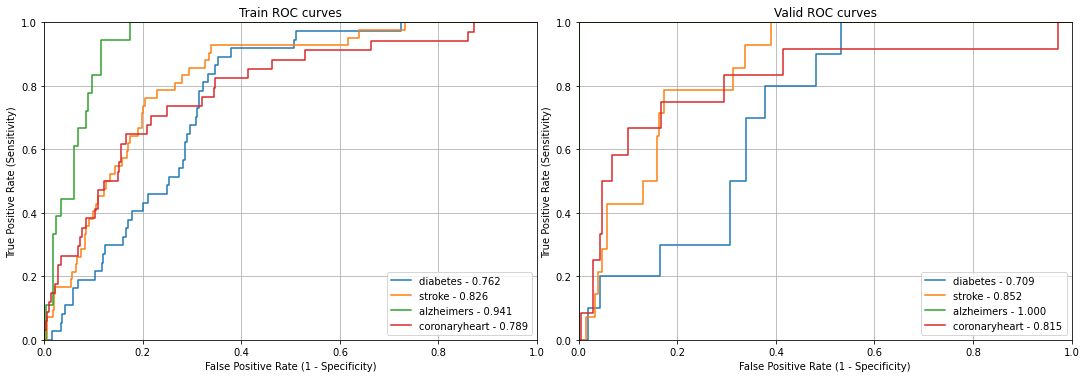

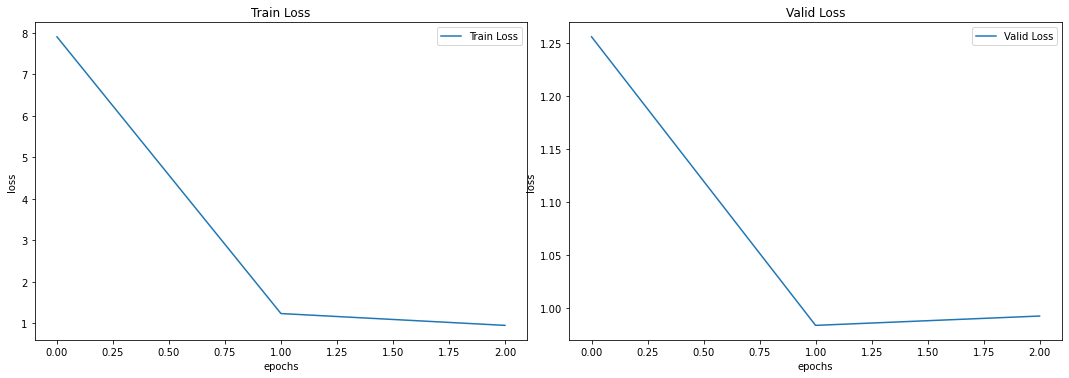

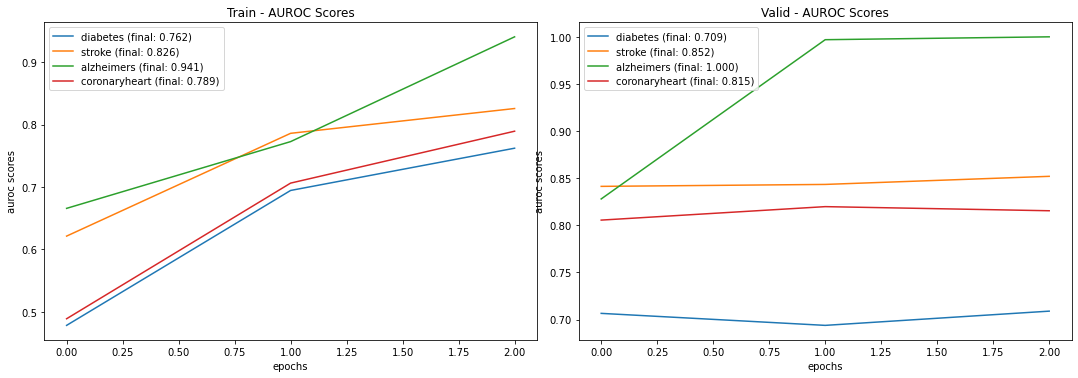

In [ ]:
lstm_base_exp.fit(3, verbosity=1)

In [ ]:
lstm_base_exp = Experiment.load('lstm_base')

Loaded experiment from /home/vinod/code/experiments/lemonade/lstm_base/lstm_base.experiment


From "/home/vinod/code/models/lemonade/lstm_base/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    3 |          0.951 | [0.812 0.854 0.927 0.760]              0.913 | [0.691 0.846 0.995 0.807]
Checkpointed to "/home/vinod/code/models/lemonade/lstm_base/checkpoint.tar"
Saved experiment to /home/vinod/code/experiments/lemonade/lstm_base/lstm_base.experiment
CPU times: user 31.6 s, sys: 1.73 s, total: 33.3 s
Wall time: 7.33 s


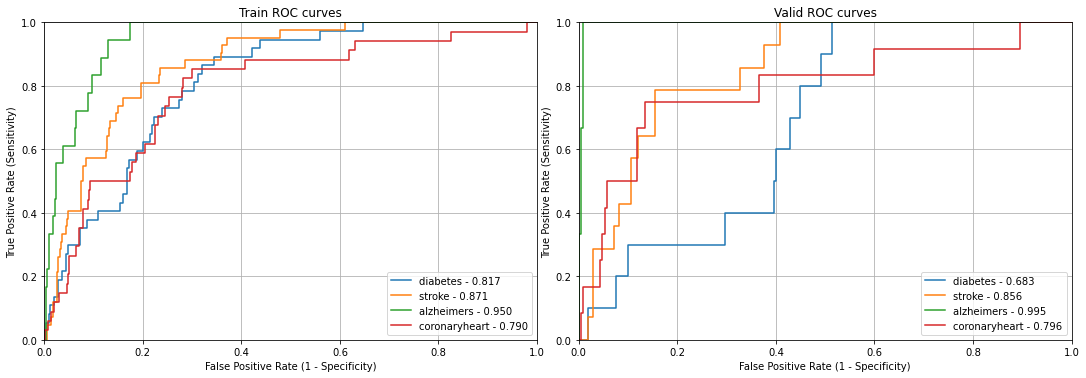

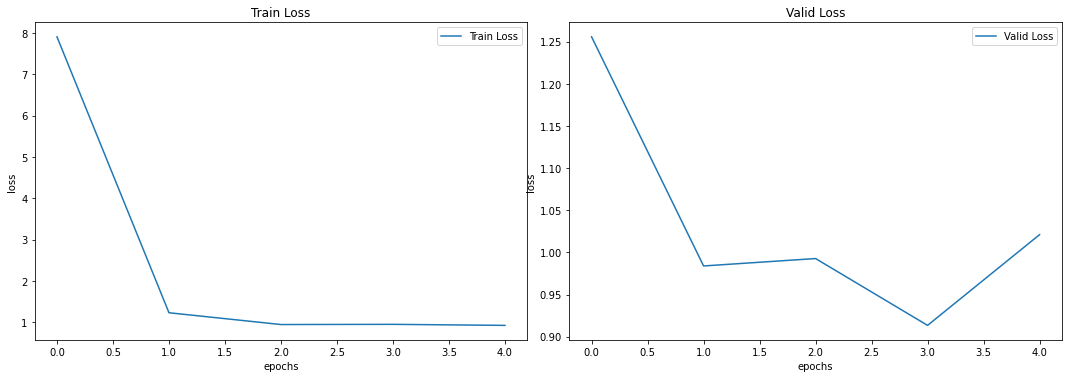

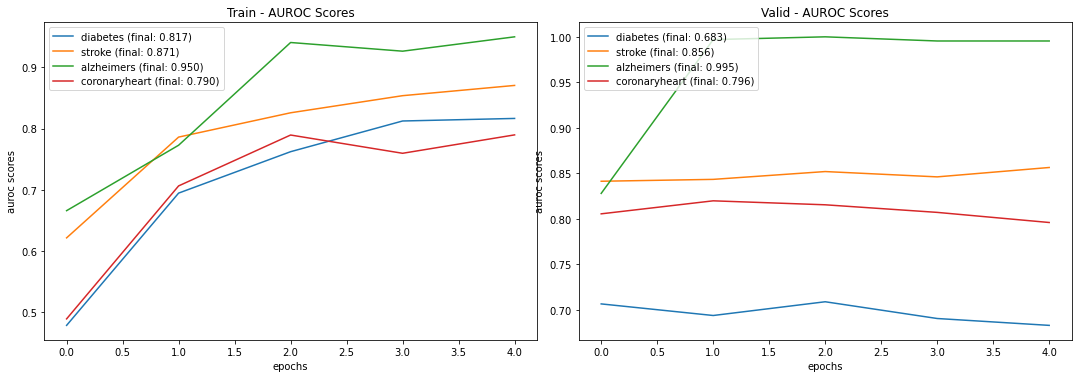

In [ ]:
%time lstm_base_exp.fit(2, from_checkpoint=True)

From "/home/vinod/code/models/lemonade/lstm_base/checkpoint.tar", loading model ...
test loss = 1.0173484086990356
test aurocs = [0.734203 0.870192 0.948387 0.798644]

Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.734203           0.687200   (0.605, 0.85)
stroke            0.870192           0.723715   (0.774, 0.95)
alzheimers        0.948387           0.889892  (0.913, 0.977)
coronaryheart     0.798644           0.815626  (0.566, 0.959)
Saved experiment to /home/vinod/code/experiments/lemonade/lstm_base/lstm_base.experiment


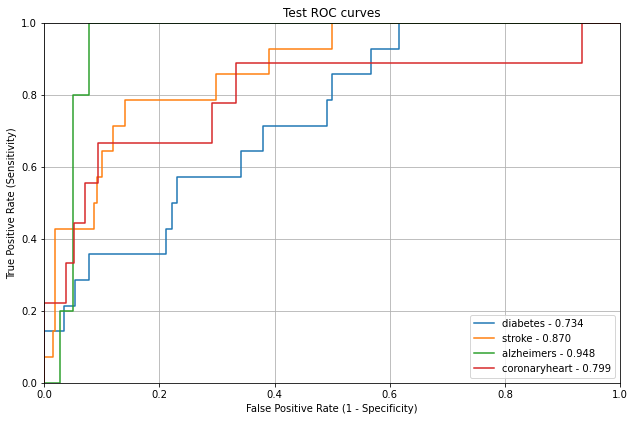

In [ ]:
lstm_base_exp.predict()

### CNN -

In [ ]:
cnn_base_exp = Experiment.create_from_file(EXP_STORE, 'cnn_base')

In [ ]:
cnn_base_exp

Experiment name: cnn_base
Description: Baseline settings for EHR_CNN experiments
Path: /home/vinod/code/experiments/lemonade/cnn_base
Labels: ['diabetes', 'stroke', 'alzheimers', 'coronaryheart']
Dataset: /home/vinod/code/datasets/synthea/1K
Model: CNN
Optim: Adagrad

epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    0 |          7.665 | [0.471 0.535 0.542 0.527]             12.114 | [0.690 0.653 0.895 0.815]
    2 |          1.700 | [0.724 0.594 0.757 0.643]              2.448 | [0.627 0.769 0.912 0.713]
Checkpointed to "/home/vinod/code/models/lemonade/cnn_base/checkpoint.tar"
Saved experiment to /home/vinod/code/experiments/lemonade/cnn_base/cnn_base.experiment


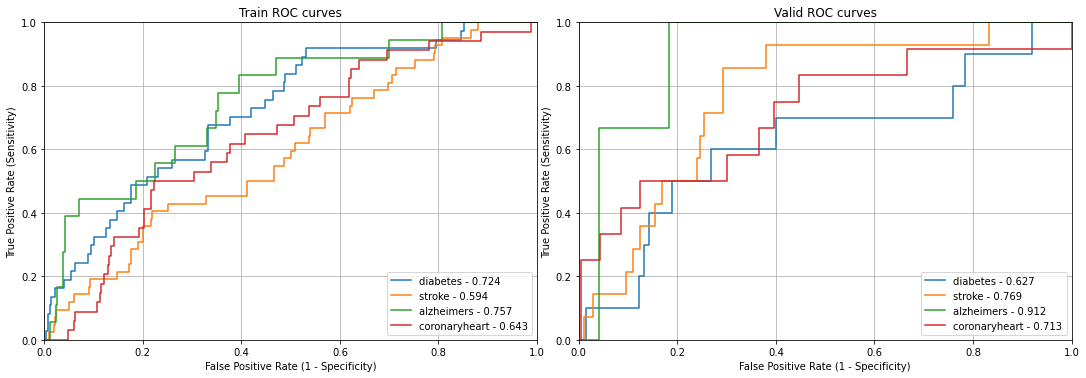

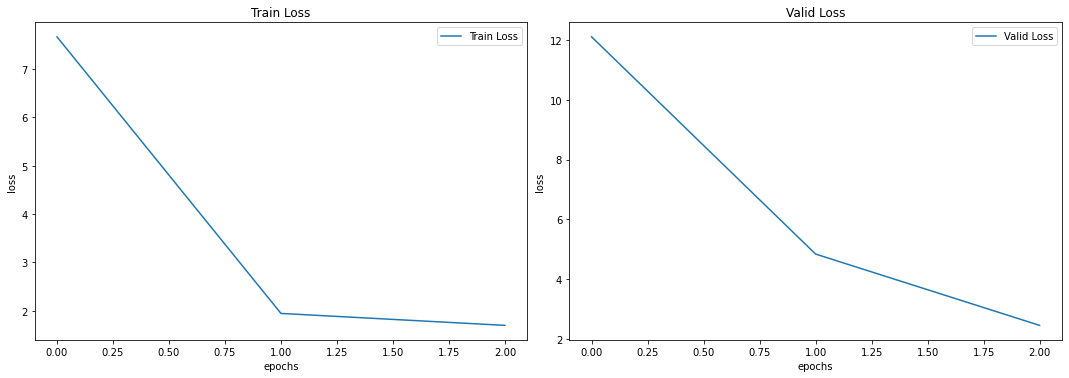

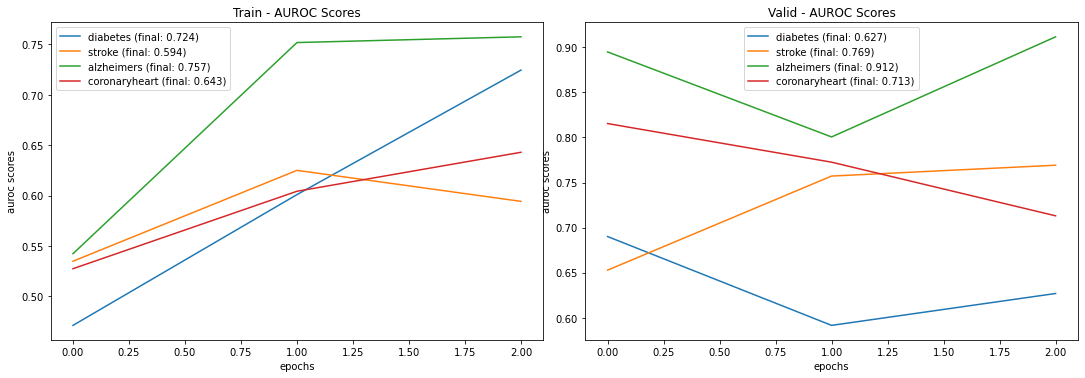

In [ ]:
cnn_base_exp.fit(3)

In [ ]:
cnn_base_exp = Experiment.load('cnn_base')

Loaded experiment from /home/vinod/code/experiments/lemonade/cnn_base/cnn_base.experiment


In [ ]:
%time cnn_base_exp.fit(2, from_checkpoint=True, plot=False)

From "/home/vinod/code/models/lemonade/cnn_base/checkpoint.tar", loading model ...
loading optimizer and epoch_index ...
epoch |     train loss |     train aurocs                  valid loss |     valid aurocs    
----------------------------------------------------------------------------------------------------
    3 |          1.388 | [0.711 0.749 0.834 0.650]              1.949 | [0.654 0.769 0.880 0.510]
Checkpointed to "/home/vinod/code/models/lemonade/cnn_base/checkpoint.tar"
Saved experiment to /home/vinod/code/experiments/lemonade/cnn_base/cnn_base.experiment
CPU times: user 7.93 s, sys: 940 ms, total: 8.87 s
Wall time: 9.04 s


From "/home/vinod/code/models/lemonade/cnn_base/checkpoint.tar", loading model ...
test loss = 1.7509491443634033
test aurocs = [0.813874 0.771978 0.889401 0.720918]

Prediction Summary ...
               auroc_score  optimal_threshold     auroc_95_ci
diabetes          0.813874           0.931660  (0.722, 0.894)
stroke            0.771978           0.785508  (0.676, 0.859)
alzheimers        0.889401           0.063971   (0.81, 0.971)
coronaryheart     0.720918           0.814477    (0.52, 0.88)
Saved experiment to /home/vinod/code/experiments/lemonade/cnn_base/cnn_base.experiment


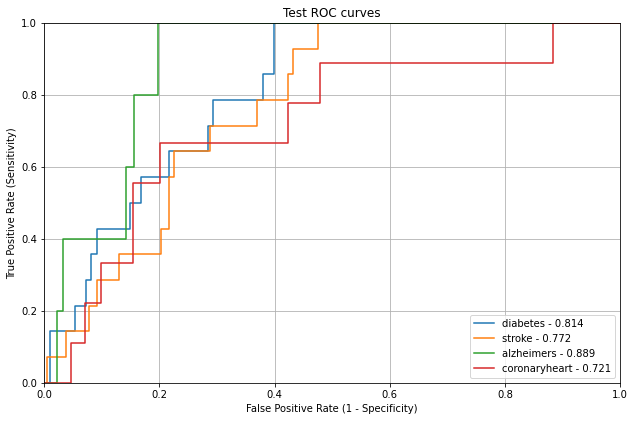

In [ ]:
cnn_base_exp.predict()

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_setup.ipynb.
Converted 01_preprocessing_clean.ipynb.
Converted 02_preprocessing_vocab.ipynb.
Converted 03_preprocessing_transform.ipynb.
Converted 04_data.ipynb.
Converted 05_metrics.ipynb.
Converted 06_learn.ipynb.
Converted 07_models.ipynb.
Converted 08_experiment.ipynb.
Converted 99_quick_walkthru.ipynb.
Converted 99_running_exps.ipynb.
Converted index.ipynb.
